# DepMap WGS and WES variant filtering and whitelisting evaluation



# Outline

- [Setup](#setup)
   - [Dependencies](#load-packages)
- [Sanity checks of variants](#sanity-checks)
- [CompareToPastRelease]()

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# %%capture
# !pip install plotly

In [3]:
# ! pip install -U kaleido

## Load packages

In [2]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from taigapy import TaigaClient
import os
tc = TaigaClient()

In [3]:
import plotly.io as pio
pio.renderers.default = "jpeg"

In [4]:
%pwd

'/home/ubuntu/depmap_omics/sandbox/dna_eval'

## Load Datasets

In [8]:
# Generate aggregated maf from remote Terra workspaces

!python combine_mafs.py

Reading cached transfers from transfers.pickled. Delete this file if you want to get a fresh snapshot of all files from Terra
[Transfer(srcs='gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/submissions/8f6e8169-3e14-467c-9f35-e703195fb6a1/run_vcf_to_depmap/3f99c523-f8b2-4cc6-b0af-9828552009e4/call-vcf_to_depmap/CDS-00rz9N-maf-coding_somatic-subset.csv.gz', cds_id='CDS-00rz9N'), Transfer(srcs='gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/submissions/8f6e8169-3e14-467c-9f35-e703195fb6a1/run_vcf_to_depmap/e9d1fdde-9303-4444-9323-13d2b778104b/call-vcf_to_depmap/cacheCopy/CDS-01bI6z-maf-coding_somatic-subset.csv.gz', cds_id='CDS-01bI6z'), Transfer(srcs='gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/submissions/8f6e8169-3e14-467c-9f35-e703195fb6a1/run_vcf_to_depmap/4dbb38ff-14fb-46b7-b074-0bf2e0fc9b13/call-vcf_to_depmap/CDS-02waxZ-maf-coding_somatic-subset.csv.gz', cds_id='CDS-02waxZ'), Transfer(srcs='gs://fc-secure-d2a2d895-a7af-4117-bdc7-652d7d268324/submissions/8f6e8169-3

In [5]:
assert os.path.exists("23Q4_mutation_maf_latest.tsv")

In [13]:
# Upload to Taiga for data version control

update = False
if update:
    new_dataset_id = tc.update_dataset(
        "23Q4_mutation_maf",
        changes_description="this is a draft for 23Q4 maf of mutation",
        upload_files=[
            {
                "path": "23Q4_mutation_maf_latest.tsv",
                "name": "MAF", # optional, will use file name if not provided
                "format": "Raw", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        add_all_existing_files=True,
    )
else:
    new_dataset_id = tc.create_dataset(
        "23Q4_mutation_maf",
        dataset_description="this is a draft for 23Q4 maf of mutation",
        upload_files=[
            {
                "path": "23Q4_mutation_maf_latest.tsv",
                "name": "MAF", # optional, will use file name if not provided
                "format": "Raw", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
    )

# new_dataset_id

Uploading MAF to S3
Finished uploading MAF to S3
Uploading MAF to Taiga
Finished uploading MAF to Taiga
Dataset created. Access it directly with this url: https://cds.team/taiga/dataset/9d4d88ab67d94c199600c6271d2aa6f6



In [6]:
%%capture
maf_variants_23q4 = tc.download_to_cache(name='23q4-mutation-maf-f431', version=1, file='MAF')  # download_to_cache for raw
maf_variants_23q4 = pd.read_table(maf_variants_23q4)

# release_standard_maf is profile-based
# release_maf_23q2 is model-based
# We removed variants without gene symbols
release_maf_23q2 = tc.get(name='internal-23q2-1e49', version=98, file='OmicsSomaticMutations')
release_standard_maf = tc.download_to_cache(name='internal-23q2-1e49', version=98, file='OmicsSomaticMutationsMAFProfile.maf')  # download_to_cache for raw
release_standard_maf_23q2 = pd.read_table(release_standard_maf)

# Sanity checks

## Sanity checks for compound variants that has multiple consequences even with --pick

- Typical examples are splicing variants that may be missense mutation as well

In [7]:
check_columns = ['pos', 'gnomadg_af', 'hess_driver', 'vep_impact', 'cosmic_tier', 'civic_score', 'clnsig', 'hugo_symbol', 'vep_mane_select', 'variant_info', 'protein_change', 'oncokb_oncogenic', 'oncokb_effect', 'oncokb_hotspot', 'rescue']

In [8]:
# splicing mutation do not have protein changes
# when co-exist with synonymous mutation or missense mutation
# there will be protein changes
maf_variants_23q4.query("variant_info.str.contains('&')")[check_columns].head()

,pos,gnomadg_af,hess_driver,vep_impact,cosmic_tier,civic_score,clnsig,hugo_symbol,vep_mane_select,variant_info,protein_change,oncokb_oncogenic,oncokb_effect,oncokb_hotspot,rescue
0,65405868,NaN,NaN,HIGH,NaN,NaN,NaN,DNAJC6,NM_001256864.2,splice_acceptor_variant&coding_sequence_variant,NaN,NaN,NaN,NaN,False
1,93119331,NaN,NaN,HIGH,NaN,NaN,NaN,MTF2,NM_007358.4,splice_acceptor_variant&coding_sequence_variant,NaN,NaN,NaN,NaN,False
6,162035318,NaN,NaN,HIGH,NaN,NaN,NaN,DPP4,NM_001935.4,splice_acceptor_variant&coding_sequence_varian...,NaN,NaN,NaN,NaN,False
14,76124755,NaN,NaN,HIGH,NaN,NaN,NaN,NUP54,NM_017426.4,splice_acceptor_variant&coding_sequence_varian...,NaN,NaN,NaN,NaN,False
15,87127021,0.0,NaN,HIGH,NaN,NaN,NaN,AFF1,NM_001166693.3,splice_acceptor_variant&coding_sequence_varian...,NaN,NaN,NaN,NaN,False


In [9]:
# Remaining compound synonymous mutations are caused by rescue
# 25 of them are from julian's papers
maf_variants_23q4.query("variant_info.str.contains('&') & variant_info.str.contains('syno')").value_counts("hess_driver"), maf_variants_23q4.query("variant_info.str.contains('&') & variant_info.str.contains('syno')").value_counts("rescue").sum()

(hess_driver
 Y    25
 dtype: int64,
 71)

In [10]:
# No missense and Synonymous mutation co-occur
# This is a sanity check that we chose only one transcript per variant
((maf_variants_23q4.variant_info.str.contains('synony')) & (maf_variants_23q4.variant_info.str.contains('mis'))).sum()

0

## Sanity checks of repeat elements

In [11]:
# Some segmental duplicates are masking the oncokb annotations
# but rescued back
maf_variants_23q4.query("segdup == 'Y'").shape, maf_variants_23q4.query("segdup == 'Y'").value_counts('oncokb_effect')

((161, 82),
 oncokb_effect
 Gain-of-function           103
 Likely Loss-of-function     26
 Likely Gain-of-function      8
 Inconclusive                 1
 dtype: int64)

In [12]:
# all of the repeat masking variants are from high impact variants on Tumor Suppressor or Oncogene
# We only whitelisting high impact mutations that locate in the Tumor Suppressor or Oncogene
maf_variants_23q4.query("rm == 'Y'").shape, maf_variants_23q4.query("rm == 'Y'").value_counts('vep_impact')

((35, 82),
 vep_impact
 HIGH    35
 dtype: int64)

## Sanity checks with St Jude clinical pipeline

In [13]:
# Miss two only St Jude InDel now

## MONOMAC1	chr11.47355346.GC.	chr11.47355353.CGCC.CC	InDel	TP53	NA
## SKNAS	chr6.156778971..GCA	chr6.156778980.GG.GCAGG	InDel
## For St Jude results to be left-aligned as well
maf_variants_23q4.loc[maf_variants_23q4.pos.isin(np.array([105272634, 41224922, 124064038, 48791113, 23803335, 7675067, 47355346, 68293321, 156778971, 226064457, 49041176]) - 1), check_columns].shape

(23, 15)

## Sanity checks of Somatic filter 

- Gnomad genome frequencies
- Gnomad exome frequencies

In [14]:
# We will not keep low frequency synonymous mutation that are never compound with splicing or other consequences
maf_variants_23q4['gnomadg_af'].describe()

count    84338.000000
mean         0.030074
std          0.097442
min          0.000000
25%          0.000007
50%          0.000007
75%          0.000007
max          0.494600
Name: gnomadg_af, dtype: float64

In [15]:
maf_variants_23q4.gnomadg_af.isnull().sum() / maf_variants_23q4.shape[0], ((maf_variants_23q4.gnomadg_af.astype('float32') < 1e-5)).sum() / maf_variants_23q4.shape[0], ((maf_variants_23q4.gnomadg_af.astype('float32') >= 1e-5)).sum() / maf_variants_23q4.shape[0]

(0.9249806087086467, 0.06540735943982295, 0.009612031851530312)

In [16]:
(maf_variants_23q4.gnomadg_af.astype('float32') >= 1e-5).sum() 

10806

In [17]:
maf_variants_23q4.shape

(1124216, 82)

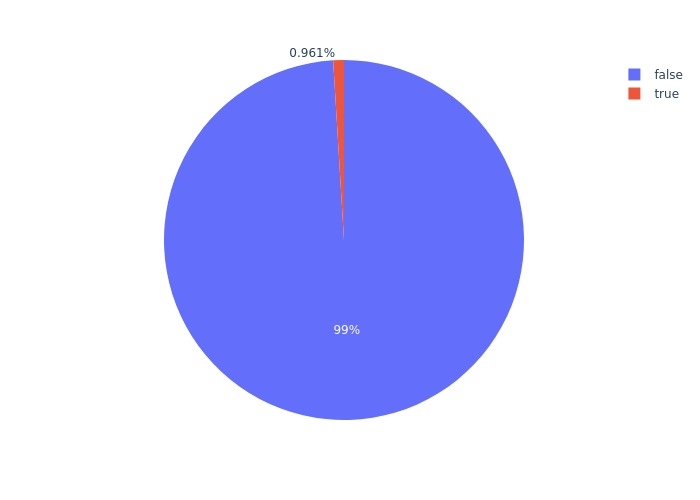

In [18]:
import plotly.express as px
fig = px.pie((maf_variants_23q4.gnomadg_af.astype('float32')>1e-5).value_counts().reset_index(), names="index", values="gnomadg_af")
fig.show()

## Sanity checks of Whitelisted variants number

In [19]:
maf_variants_23q4.rescue.dropna().shape

(1124216,)

In [20]:
maf_variants_23q4.rescue.dropna().sum(), maf_variants_23q4.rescue.dropna().shape[0]

(28329, 1124216)

In [21]:
# Majority of simple synonymous mutations are rescued by Julian's paper
# Let's remove hess_driver in rescue list
maf_variants_23q4.query("variant_info.str.contains('syno')")[check_columns].value_counts("hess_driver"), (maf_variants_23q4.hess_driver == 'Y').sum()

(hess_driver
 Y    278
 dtype: int64,
 3959)

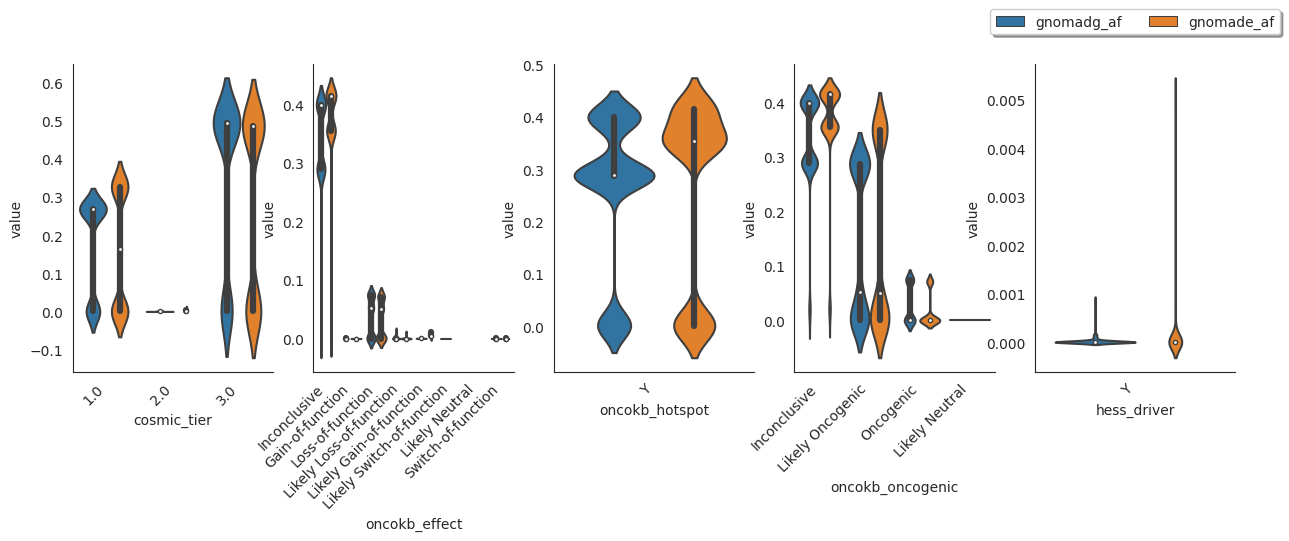

In [22]:
rescued_maf_variants = maf_variants_23q4.loc[maf_variants_23q4.rescue, :]
rescued_maf_variants_sub_categores = rescued_maf_variants.loc[:, ['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver', 'gnomadg_af', 'gnomade_af']].melt(id_vars=['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver'])

## Majority of the oncoKB hotspot mutation are also very pemissive
## They will introduce inclusive oncoKB mutation effects 
## Let's remove hotspot mutation for whitelisting ..
## May consider run hotspot method later

sns.set_style("white")
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(15, 4)
ax = ax.flatten()

sns.violinplot(data=rescued_maf_variants_sub_categores, x='cosmic_tier', y='value', hue='variable', ax=ax[0])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_effect', y='value', hue='variable', ax=ax[1])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_hotspot', y='value', hue='variable', ax=ax[2])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_oncogenic', y='value', hue='variable', ax=ax[3])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='hess_driver', y='value', hue='variable', ax=ax[4])

for ax_index, curr_ax in enumerate(ax):
    for tick in curr_ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
        sns.despine()
        if ax_index == 4:
            curr_ax.legend(bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True, loc='upper center')
        else:
            curr_ax.legend().set_visible(False)
#plt.tight_layout()


In [23]:
count_rescued = pd.DataFrame(rescued_maf_variants.groupby("cds_id").apply(lambda x: x.shape[0])).reset_index().rename(
    columns={0: 'count'}
)

In [24]:
count_rescued.loc[:, 'count'].sum(), count_rescued.loc[:, 'count'].mean()

(28329, 9.658711217183772)

Text(0.5, 0, 'Rescue variants for 2937 samples')

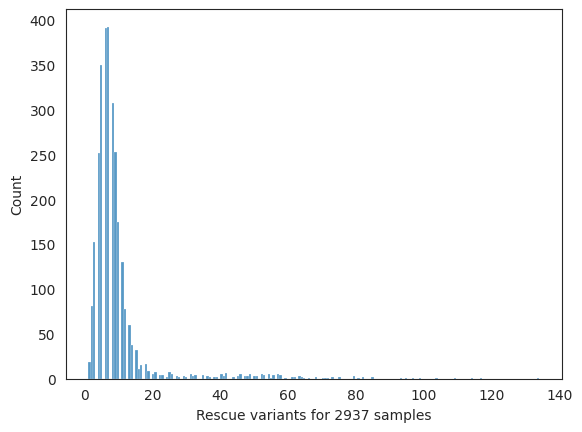

In [25]:
sns.histplot(count_rescued, x='count')
plt.xlabel("Rescue variants for 2937 samples")

# fig, ax = plt.subplots(2, 2)
# sns.histplot(rescued_maf_variants.gnomadg_af, bins=50, ax=ax[0][0])
# sns.kdeplot(rescued_maf_variants.gnomadg_af, ax=ax[0][1])
# sns.histplot(rescued_maf_variants.gnomade_af, bins=50, ax=ax[1][0])
# sns.kdeplot(rescued_maf_variants.gnomade_af, ax=ax[1][1])
# fig.set_size_inches(7, 5)
# fig.tight_layout()

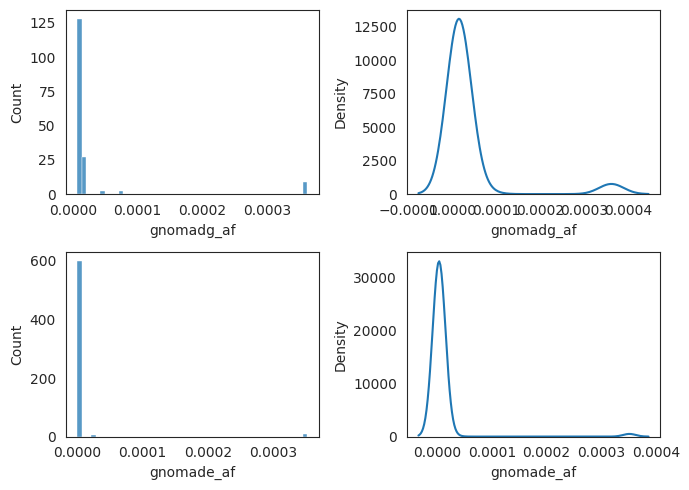

In [26]:
# Civic score has been removed from the rescue list
fig, ax = plt.subplots(2, 2)
sns.histplot(rescued_maf_variants.query('civic_score >= 50').gnomadg_af, bins=50, ax=ax[0][0])
sns.kdeplot(rescued_maf_variants.query('civic_score >= 50').gnomadg_af, ax=ax[0][1])
sns.histplot(rescued_maf_variants.query('civic_score >= 50').gnomade_af, bins=50, ax=ax[1][0])
sns.kdeplot(rescued_maf_variants.query('civic_score >= 50').gnomade_af, ax=ax[1][1])
fig.set_size_inches(7, 5)
fig.tight_layout()

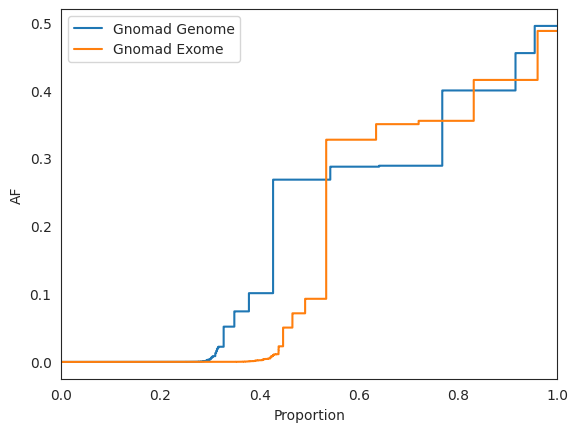

In [27]:
sns.ecdfplot(data=rescued_maf_variants, y="gnomadg_af", label='Gnomad Genome')
sns.ecdfplot(data=rescued_maf_variants, y="gnomade_af", label='Gnomad Exome')
plt.ylabel("AF")
plt.legend()

# Remove some rescue list to finalize a maf file

In [28]:
# Turn off hotspot rescue list 
# for both oncoKB and hess driver
maf_variants_23q4_clean = maf_variants_23q4.query("(oncokb_hotspot == 'Y') | (hess_driver == 'Y')")

# Only remove the hotspot with synonymous mutations and high allele frequency
maf_variants_23q4_clean = maf_variants_23q4.drop(maf_variants_23q4_clean.index[((maf_variants_23q4_clean.gnomadg_af > 1e-1) | (maf_variants_23q4_clean.gnomade_af > 1e-1)) & (maf_variants_23q4_clean.variant_info.str.contains("^syno", regex=True))], axis=0)

In [29]:
# With above filter of rescue list
# We still have ~110 synonymous mutations
# Remove synonymous mutation even with low gnomad af
# Unless there is very strong oncoKB support 
# any variants with leftmost (strongest) consequence is synonymous mutation 
# will be removed

maf_variants_23q4_clean = maf_variants_23q4_clean.loc[~maf_variants_23q4_clean.variant_info.str.contains('^synony', regex=True), ]

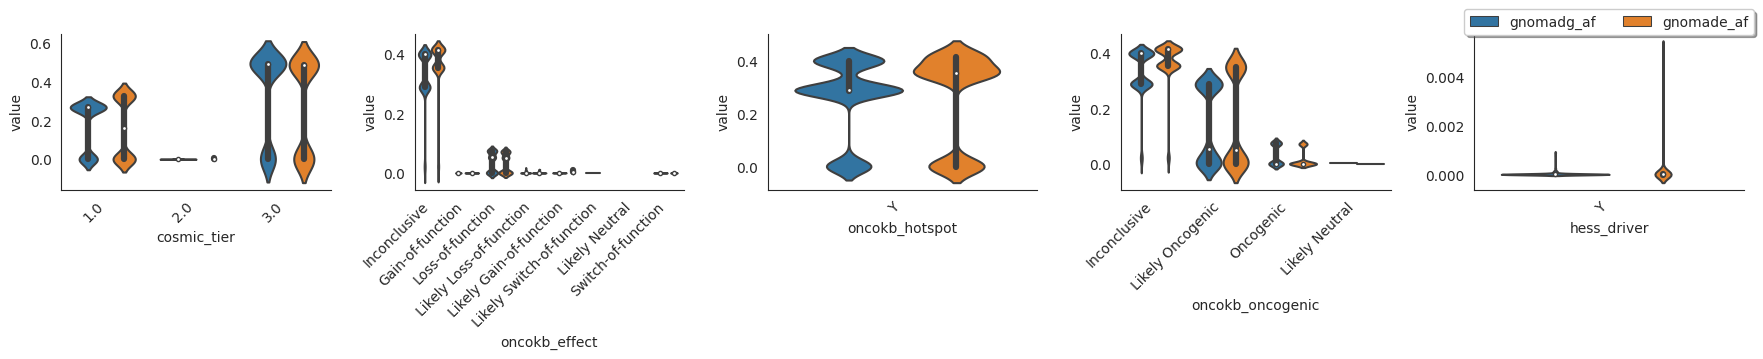

In [30]:
# Double check after removing hotspot rescue
rescued_maf_variants = maf_variants_23q4_clean.loc[maf_variants_23q4_clean.rescue, :]
rescued_maf_variants_sub_categores = rescued_maf_variants.loc[:, ['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver', 'gnomadg_af', 'gnomade_af']].melt(id_vars=['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver'])

## Majority of the oncoKB hotspot mutation are also very pemissive
## They will introduce inclusive oncoKB mutation effects 
## Let's remove hotspot mutation for whitelisting ..
## May consider run hotspot method later

sns.set_style("white")
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(18, 4)
ax = ax.flatten()

sns.violinplot(data=rescued_maf_variants_sub_categores, x='cosmic_tier', y='value', hue='variable', ax=ax[0])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_effect', y='value', hue='variable', ax=ax[1])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_hotspot', y='value', hue='variable', ax=ax[2])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_oncogenic', y='value', hue='variable', ax=ax[3])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='hess_driver', y='value', hue='variable', ax=ax[4])

for ax_index, curr_ax in enumerate(ax):
    for tick in curr_ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
        sns.despine()
        if ax_index == 4:
            curr_ax.legend(bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True, loc='upper center')
        else:
            curr_ax.legend().set_visible(False)
plt.tight_layout()

In [31]:
# Turn off oncoKB hotspot rescue list  
maf_variants_23q4_oncokb = maf_variants_23q4_clean.query("(oncokb_hotspot == 'Y')")

# Only remove the hotspot with synonymous mutations and high allele frequency
maf_variants_23q4_clean = maf_variants_23q4_clean.drop(maf_variants_23q4_oncokb.index[((maf_variants_23q4_oncokb.gnomadg_af > 1e-1) | (maf_variants_23q4_oncokb.gnomade_af > 1e-1)) | \
                                                                                       (maf_variants_23q4_oncokb.oncokb_effect.str.contains("^Inconclusive", regex=True))], axis=0)
maf_variants_23q4_clean.shape                                                                                    

(1119156, 82)

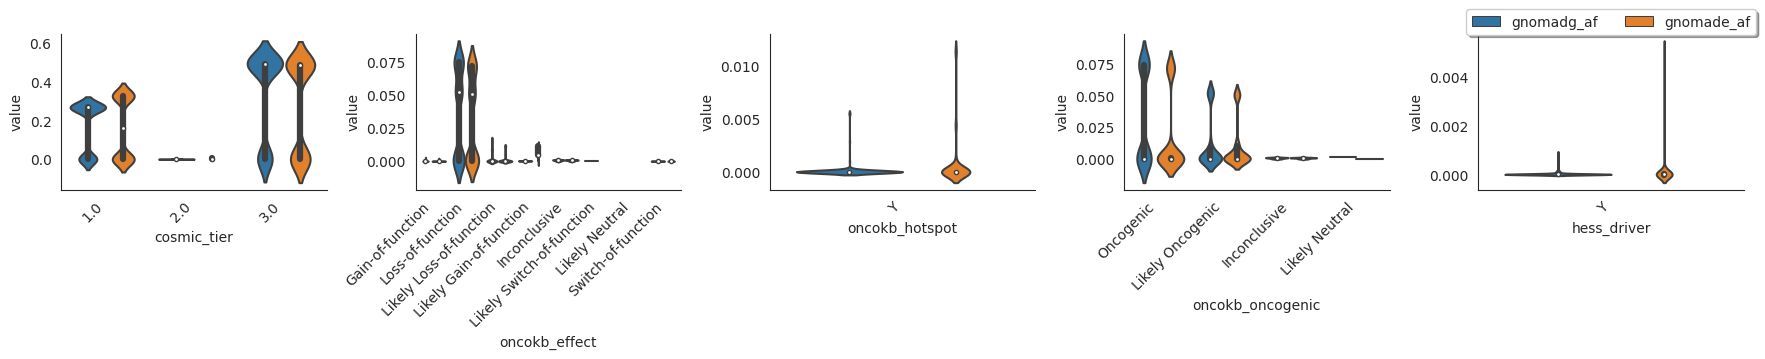

In [32]:
# Double check after removing hotspot rescue
rescued_maf_variants = maf_variants_23q4_clean.loc[maf_variants_23q4_clean.rescue, :]
rescued_maf_variants_sub_categores = rescued_maf_variants.loc[:, ['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver', 'gnomadg_af', 'gnomade_af']].melt(id_vars=['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver'])

## Majority of the oncoKB hotspot mutation are also very pemissive
## They will introduce inclusive oncoKB mutation effects 
## Let's remove hotspot mutation for whitelisting ..
## May consider run hotspot method later

sns.set_style("white")
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(18, 4)
ax = ax.flatten()

sns.violinplot(data=rescued_maf_variants_sub_categores, x='cosmic_tier', y='value', hue='variable', ax=ax[0])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_effect', y='value', hue='variable', ax=ax[1])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_hotspot', y='value', hue='variable', ax=ax[2])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_oncogenic', y='value', hue='variable', ax=ax[3])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='hess_driver', y='value', hue='variable', ax=ax[4])

for ax_index, curr_ax in enumerate(ax):
    for tick in curr_ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
        sns.despine()
        if ax_index == 4:
            curr_ax.legend(bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True, loc='upper center')
        else:
            curr_ax.legend().set_visible(False)
plt.tight_layout()

In [33]:
# Trim COSMIC tier 1 with high frequency
maf_variants_23q4_cosmic = maf_variants_23q4_clean.query("(cosmic_tier == 1) | (cosmic_tier == 3)")

# Only remove the hotspot with synonymous mutations and high allele frequency
maf_variants_23q4_clean = maf_variants_23q4_clean.drop(maf_variants_23q4_cosmic.index[((maf_variants_23q4_cosmic.gnomadg_af > 1e-1) | (maf_variants_23q4_cosmic.gnomade_af > 1e-1))], axis=0)

maf_variants_23q4_clean.shape                                                                                    

(1117155, 82)

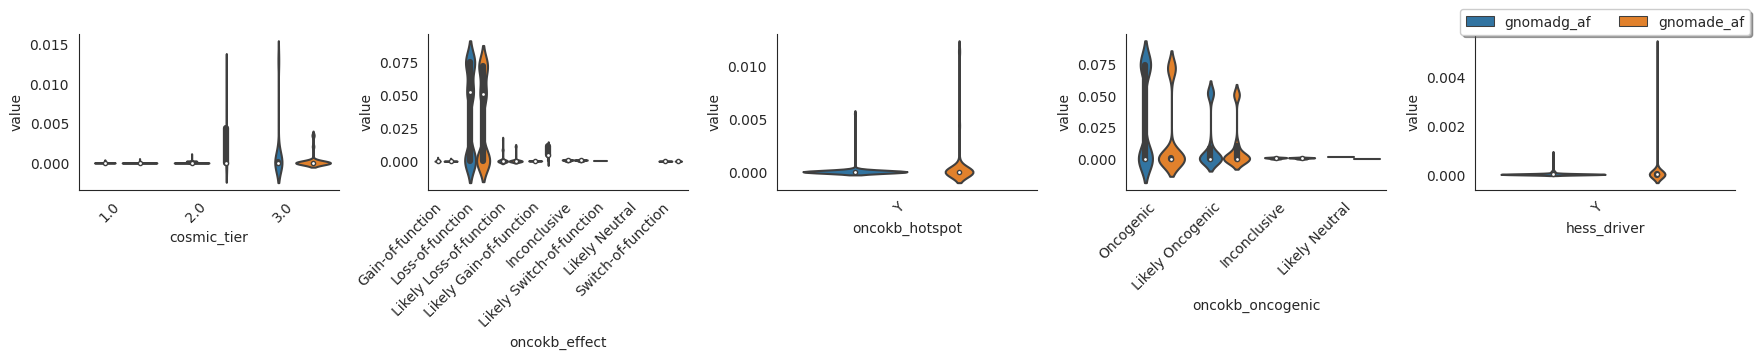

In [34]:
# Double check after removing hotspot rescue
rescued_maf_variants = maf_variants_23q4_clean.loc[maf_variants_23q4_clean.rescue, :]
rescued_maf_variants_sub_categores = rescued_maf_variants.loc[:, ['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver', 'gnomadg_af', 'gnomade_af']].melt(id_vars=['cosmic_tier', 'oncokb_effect', 'oncokb_hotspot', 'oncokb_oncogenic', 'hess_driver'])

## Majority of the oncoKB hotspot mutation are also very pemissive
## They will introduce inclusive oncoKB mutation effects 
## Let's remove hotspot mutation for whitelisting ..
## May consider run hotspot method later

sns.set_style("white")
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(18, 4)
ax = ax.flatten()

sns.violinplot(data=rescued_maf_variants_sub_categores, x='cosmic_tier', y='value', hue='variable', ax=ax[0])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_effect', y='value', hue='variable', ax=ax[1])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_hotspot', y='value', hue='variable', ax=ax[2])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='oncokb_oncogenic', y='value', hue='variable', ax=ax[3])
sns.violinplot(data=rescued_maf_variants_sub_categores, x='hess_driver', y='value', hue='variable', ax=ax[4])

for ax_index, curr_ax in enumerate(ax):
    for tick in curr_ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
        sns.despine()
        if ax_index == 4:
            curr_ax.legend(bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True, shadow=True, loc='upper center')
        else:
            curr_ax.legend().set_visible(False)
plt.tight_layout()

In [35]:
count_rescued = pd.DataFrame(rescued_maf_variants.groupby("cds_id").apply(lambda x: x.shape[0])).reset_index().rename(
    columns={0: 'count'}
)

count_rescued.mean()

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_21578/1973614276.py:5: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



count    7.413036
dtype: float64

In [36]:
count_rescued.loc[:, 'count'].sum()

21268

<Axes: xlabel='count', ylabel='Count'>

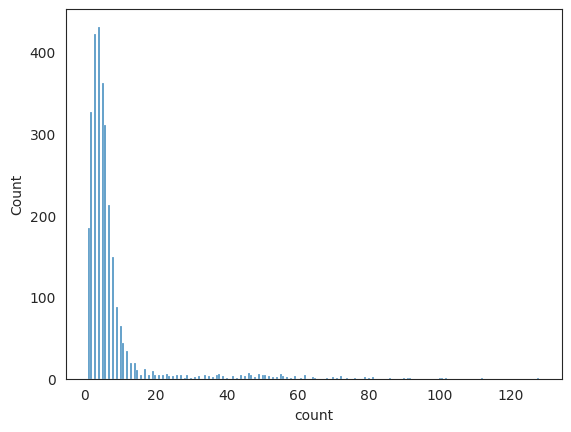

In [37]:
sns.histplot(count_rescued, x='count')

In [38]:
# Still have 71 variants with secondary effect belonging to synonymous mutation 
# Will be assigned to be silent mutation later according to maftools
# That seems to be important in oncoKB 

maf_variants_23q4_clean.query("variant_info.str.contains('syno')")[['ref','alt', 'cds_id']+check_columns].head()

,ref,alt,cds_id,pos,gnomadg_af,hess_driver,vep_impact,cosmic_tier,civic_score,clnsig,hugo_symbol,vep_mane_select,variant_info,protein_change,oncokb_oncogenic,oncokb_effect,oncokb_hotspot,rescue
608,G,A,CDS-02waxZ,136517753,0.000677,NaN,LOW,NaN,NaN,Benign/Likely_benign,NOTCH1,NM_017617.5,splice_region_variant&synonymous_variant,ENSP00000498587.1:p.Pro480=,Oncogenic,Likely Loss-of-function,NaN,True
10383,C,T,CDS-0Xzmie,7675994,0.000007,Y,LOW,NaN,NaN,Pathogenic,TP53,NM_000546.6,splice_region_variant&synonymous_variant,ENSP00000269305.4:p.Thr125=,Likely Oncogenic,Likely Loss-of-function,Y,True
46530,G,A,CDS-3xk0fX,69396546,0.000511,NaN,LOW,NaN,NaN,NaN,RAD17,NM_133338.3,splice_region_variant&synonymous_variant,ENSP00000346938.5:p.Lys524=,Likely Oncogenic,Loss-of-function,NaN,True
47198,C,T,CDS-3ycMVI,7675994,0.000007,Y,LOW,NaN,NaN,Pathogenic,TP53,NM_000546.6,splice_region_variant&synonymous_variant,ENSP00000269305.4:p.Thr125=,Likely Oncogenic,Likely Loss-of-function,Y,True
48290,G,A,CDS-4aIXe6,69396546,0.000511,NaN,LOW,NaN,NaN,NaN,RAD17,NM_133338.3,splice_region_variant&synonymous_variant,ENSP00000346938.5:p.Lys524=,Likely Oncogenic,Loss-of-function,NaN,True


## Double check clean MAF overlaped with St Jude

In [40]:
maf_variants_23q4_clean.loc[maf_variants_23q4_clean.pos.isin(np.array([105272634, 41224922, 124064038, 48791113, 23803335, 7675067, 47355346, 68293321, 156778971, 226064457, 49041176]) - 1), check_columns].shape

(23, 15)

# VCF 2 MAF standardised formatting to output 

## Convert coordinate and add essential standard MAF columns

In [41]:
def GetMafEndPosition(start: int, ref: str, alt: str) -> tuple:
    """Get the end position from the VCF start position and ref alt alleles

    Learn the complex InDel from https://github.com/qinqian/vcf2maf/blob/main/vcf2maf.pl#L706


    Return
    -----------
    (start, vartype, inframe): tuple
    """
    assert len(ref) > 0
    assert len(alt) > 0
    if len(ref) == len(alt):
        var_type_dict = {1: "SNP", 2: "DNP", 3: "TNP"}
        inframe = False
        if len(alt) > 3:
            var_type = "ONP"
        else:
            var_type = var_type_dict[len(alt)]
        return start, start + len(alt) - 1, var_type, inframe
    elif len(ref) < len(alt):
        # Insertion
        var_type = "INS";
        inframe = abs(len(ref) - len(alt)) % 3 == 0
        if ref == "-":
            return start - 1, start, var_type, inframe
        else:
            return start, start + len(ref) - 1, var_type, inframe
    else:
        # Deletion
        inframe = abs(len(ref) - len(alt)) % 3 == 0
        var_type = 'DEL'
        return start, start + len(ref) - 1, var_type, inframe

In [42]:
formatted_coords = maf_variants_23q4_clean.loc[:, ['pos', 'ref', 'alt']].apply(lambda x: GetMafEndPosition(*x), axis=1, result_type="expand")

In [43]:
import re

def GetVariantClassification(vep_seq_ontology: str, var_type: str, inframe: bool) -> str:
    """Map VEP sequence ontology into MAF variant classifications,
    VEP consequences is ordered by http://useast.ensembl.org/info/genome/variation/prediction/predicted_data.html"""

    if re.match(r"^(splice_acceptor_variant|splice_donor_variant|transcript_ablation|exon_loss_variant)", vep_seq_ontology):
        return "Splice_Site"
    
    if re.match(r"^(stop_gained)", vep_seq_ontology):
        return "Nonsense_Mutation"

    if (re.match(r"^(frameshift_variant)", vep_seq_ontology) or (re.match(r"^(protein_altering_variant)", vep_seq_ontology) and not inframe)) and (var_type == 'DEL'):
        return "Frame_Shift_Del"

    if (re.match(r"^(frameshift_variant)", vep_seq_ontology) or (re.match(r"^(protein_altering_variant)", vep_seq_ontology) and not inframe)) and (var_type == 'INS'):
        return "Frame_Shift_Ins"
    
    if re.match(r"^(stop_lost)", vep_seq_ontology):
        return "Nonstop_Mutation"
    
    if re.match(r"^(initiator_codon_variant|start_lost)", vep_seq_ontology):
        return "Translation_Start_Site" 

    if re.match(r"^(inframe_insertion|conservative_inframe_insertion|disruptive_inframe_insertion)", vep_seq_ontology) or (re.match(r"^(protein_altering_variant)", vep_seq_ontology) and inframe and (var_type == 'INS')):
        return "In_Frame_Ins"

    if re.match(r"^(inframe_deletion|disruptive_inframe_deletion|conservative_inframe_deletion)", vep_seq_ontology) or (re.match(r"^(protein_altering_variant)", vep_seq_ontology) and inframe and (var_type == 'DEL')):
        return "In_Frame_Del"

    if re.match(r"^(missense_variant|coding_sequence_variant|conservative_missense_variant|rare_amino_acid_variant)", vep_seq_ontology):
        return "Missense_Mutation"

    if re.match(r"^(transcript_amplification|intron_variant|INTRAGENIC|intragenic_variant)", vep_seq_ontology):
        return "Intron"

    if re.match(r"^(incomplete_terminal_codon_variant|synonymous_variant|stop_retained_variant|NMD_transcript_variant|start_retained_variant)", vep_seq_ontology):
        return "Silent"

    if re.match(r"^(splice_region_variant|splice_polypyrimidine_tract_variant|splice_donor_5th_base_variant|splice_donor_region_variant)", vep_seq_ontology):
        return "Splice_Region"

    if re.match(r"^(mature_miRNA_variant|exon_variant|non_coding_exon_variant|non_coding_transcript_exon_variant|non_coding_transcript_variant|nc_transcript_variant|coding_transcript_variant)", vep_seq_ontology):
        return "RNA"

    if re.match(r"^(5_prime_UTR_variant|5_prime_UTR_premature_start_codon_gain_variant)", vep_seq_ontology):
        return "5'UTR"

    if re.match(r"^3_prime_UTR_variant", vep_seq_ontology):
        return "3'UTR"

    if re.match(r"^upstream_gene_variant", vep_seq_ontology):
        return "5'Flank"

    if re.match(r"^downstream_gene_variant", vep_seq_ontology):
        return "3'Flank"

    if re.match(r"^(TF_binding_site_variant|regulatory_region_variant|regulatory_region|intergenic_variant|intergenic_region)", vep_seq_ontology):
        return "IGR" 

    if vep_seq_ontology == "":
        return "NoAnnotation"

    return "TargetedRegion"


In [44]:
maf_variants_23q4_clean['Start_Position'] = formatted_coords[0]
maf_variants_23q4_clean['End_Position'] = formatted_coords[1]
maf_variants_23q4_clean['Variant_Type'] = formatted_coords[2]
maf_variants_23q4_clean['InFrame'] = formatted_coords[3]
maf_variants_23q4_clean['Variant_Classification'] = maf_variants_23q4_clean.loc[:, ['variant_info', 'Variant_Type', 'InFrame']].apply(lambda x: GetVariantClassification(*x), axis=1)

In [45]:
maf_variants_23q4_clean.shape, maf_variants_23q4_clean.query("Variant_Classification == 'Silent'").values

((1117155, 87),
 array([[110838, 'chr14', 105865551, 'T', 'TA', 0.75, 2, 0, 2, '0|1',
         105865532.0, 'insertion',
         'incomplete_terminal_codon_variant&coding_sequence_variant',
         'ENST00000439842.1:c.10_11insT', 'ENSP00000418639.1:p.Ter4Val',
         'IGHD7-27', 'ENSG00000236597', 'ENST00000439842',
         'immunoglobulin heavy diversity 7-27',
         'Immunoglobulin heavy locus at 14q32.33', nan, nan, 0.6475, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, 'LOW', 'IG_D_gene',
         'HGNC:5518', nan, nan, 'ENSP00000418639', nan, nan, nan, nan,
         nan, nan, nan, nan, nan, False, False, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, 7.3, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         False, 'CDS-Qkc4aS', 105865551, 105865551, 'INS', False,
         'Silent']], dtype=object))

In [46]:
# Remove the silent mutation that are mixed with missense mutation 
# Using different consequeces names

maf_variants_23q4_clean = maf_variants_23q4_clean.query("Variant_Classification != 'Silent'")

In [47]:
# No missing annotations
maf_variants_23q4_clean.loc[maf_variants_23q4_clean.Variant_Classification == 'TargetedRegion', ['ref', 'alt', 'variant_info', 'Variant_Classification', 'variant_info', 'Variant_Type', 'InFrame']].values

array([], shape=(0, 7), dtype=object)

In [48]:
maf_variants_23q4_clean.Variant_Classification.unique()

array(['Splice_Site', 'Missense_Mutation', 'In_Frame_Del',
       'Frame_Shift_Del', 'Nonsense_Mutation', 'Frame_Shift_Ins',
       'Nonstop_Mutation', 'Splice_Region', "5'Flank", 'In_Frame_Ins',
       'Translation_Start_Site', "3'Flank", 'Intron', "5'UTR", 'RNA'],
      dtype=object)

In [49]:
maf_variants_23q4_clean.head()

,0915,chrom,pos,ref,alt,af,dp,ref_count,alt_count,gt,...,provean_prediction,segdup,rm,rescue,cds_id,Start_Position,End_Position,Variant_Type,InFrame,Variant_Classification
0,11664,chr1,65405868,AGG,TTT,0.180,20,17,3,0|1,...,NaN,NaN,NaN,False,CDS-051M8l,65405868,65405870,TNP,False,Splice_Site
1,14623,chr1,93119331,AGA,TTT,0.241,63,47,16,0|1,...,NaN,NaN,NaN,False,CDS-051M8l,93119331,93119333,TNP,False,Splice_Site
2,23806,chr1,173506861,C,T,0.583,96,39,57,0/1,...,Neutral,NaN,NaN,False,CDS-051M8l,173506861,173506861,SNP,False,Missense_Mutation
3,55310,chr2,113186248,G,T,0.231,11,9,2,0/1,...,Neutral,NaN,NaN,False,CDS-051M8l,113186248,113186248,SNP,False,Missense_Mutation
4,58985,chr2,151379526,ACTT,A,0.240,27,21,6,0|1,...,NaN,NaN,NaN,False,CDS-051M8l,151379526,151379529,DEL,True,In_Frame_Del


## Reorder columns to keep consistent with MAF standards

In [50]:
maf_variants_23q4_clean.columns

Index(['0915', 'chrom', 'pos', 'ref', 'alt', 'af', 'dp', 'ref_count',
       'alt_count', 'gt', 'ps', 'variant_type', 'variant_info', 'dna_change',
       'protein_change', 'hugo_symbol', 'ensembl_gene_id',
       'ensembl_feature_id', 'hgnc_name', 'hgnc_family', 'uniprot_id',
       'dbsnp_rs_id', 'gc_content', 'lof_gene_name', 'lof_gene_id',
       'lof_number_of_transcripts_in_gene',
       'lof_percent_of_transcripts_affected', 'nmd', 'clnsig',
       'molecular_consequence', 'af_exac', 'af_esp', 'af_tgp', 'vep_impact',
       'vep_biotype', 'vep_hgnc_id', 'vep_existing_variation',
       'vep_mane_select', 'vep_ensp', 'vep_swissprot', 'sift', 'polyphen',
       'gnomade_af', 'gnomadg_af', 'vep_clin_sig', 'vep_somatic',
       'vep_pli_gene_value', 'vep_loftool', 'oncogene_high_impact',
       'tumor_suppressor_high_impact', 'achilles_top_genes',
       'structural_relation', 'associated_with', 'lof', 'driver',
       'likely_driver', 'transcript_likely_lof', 'brca1_func_score',
  

In [51]:
maf_variants_23q4_clean['Strand'] = '+'
maf_variants_23q4_clean.rename(
    columns={
        "hugo_symbol": "Hugo_Symbol",
        "chrom": "Chromosome",
        "ref": "Reference_Allele",
        "alt": "Alternate_Allele",
        "cds_id": "Tumor_Sample_Barcode",
        "protein_change": "Protein_Change",
    },
    inplace=True,
)

In [52]:
maf_variants_23q4_clean.loc[:, "NCBI_Build"] = "GRCh38" 
maf_variants_23q4_clean.loc[:, "Center"] = "DepMap" 

In [53]:
maf_variants_23q4_clean.loc[:, "Tumor_Seq_Allele1"] = maf_variants_23q4_clean.loc[
    :, "Reference_Allele"
] 
maf_variants_23q4_clean.loc[:, "Tumor_Seq_Allele2"] = maf_variants_23q4_clean.loc[:, "Alternate_Allele"]

In [54]:
reordered_columns = [
        "Hugo_Symbol",
        "NCBI_Build",
        "Chromosome",
        "Start_Position",
        "End_Position",
        "Variant_Type",
        "Reference_Allele",
        "Tumor_Seq_Allele1",
        "Tumor_Seq_Allele2",
        "Tumor_Sample_Barcode",
        "Variant_Classification",
        "Protein_Change",
    ] 

In [55]:
reordered_columns += list(set(maf_variants_23q4_clean.columns) - set(reordered_columns))

In [56]:
maf_variants_23q4_clean = maf_variants_23q4_clean.loc[:, reordered_columns]

In [57]:
maf_variants_23q4_clean.shape

(1117154, 92)

In [58]:
maf_variants_23q4_clean.head()

,Hugo_Symbol,NCBI_Build,Chromosome,Start_Position,End_Position,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,...,oncogene_high_impact,vep_biotype,driver,oncokb_hotspot,hess_driver,lof_percent_of_transcripts_affected,lof_gene_name,transcript_likely_lof,dna_change,likely_driver
0,DNAJC6,GRCh38,chr1,65405868,65405870,TNP,AGG,AGG,TTT,CDS-051M8l,...,False,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000371069.5:c.2228-2_2228delinsTTT,NaN
1,MTF2,GRCh38,chr1,93119331,93119333,TNP,AGA,AGA,TTT,CDS-051M8l,...,False,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000370298.9:c.729-2_729delinsTTT,NaN
2,SLC9C2,GRCh38,chr1,173506861,173506861,SNP,C,C,T,CDS-051M8l,...,False,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000367714.4:c.3220G>A,NaN
3,PSD4,GRCh38,chr2,113186248,113186248,SNP,G,G,T,CDS-051M8l,...,False,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000245796.11:c.1621G>T,NaN
4,TNFAIP6,GRCh38,chr2,151379526,151379529,DEL,ACTT,ACTT,A,CDS-051M8l,...,False,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000243347.5:c.828_830del,NaN


In [59]:
maf_variants_23q4_clean.Variant_Classification.unique()

array(['Splice_Site', 'Missense_Mutation', 'In_Frame_Del',
       'Frame_Shift_Del', 'Nonsense_Mutation', 'Frame_Shift_Ins',
       'Nonstop_Mutation', 'Splice_Region', "5'Flank", 'In_Frame_Ins',
       'Translation_Start_Site', "3'Flank", 'Intron', "5'UTR", 'RNA'],
      dtype=object)

Text(0, 0.5, 'Variant Count')

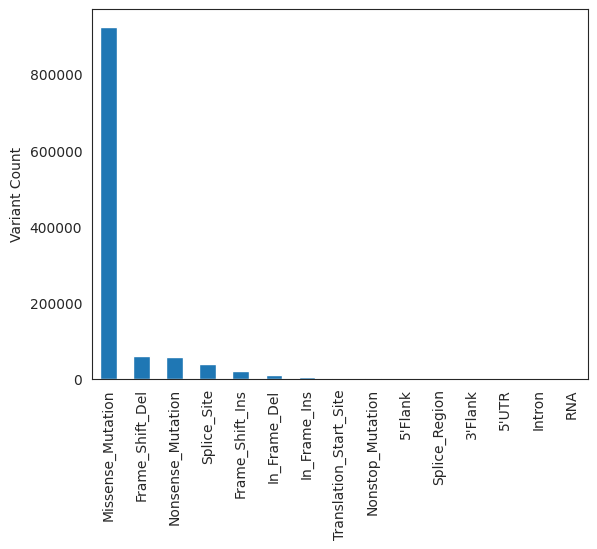

In [60]:
sns.set_style("white")
maf_variants_23q4_clean.Variant_Classification.value_counts().plot.bar()
plt.ylabel("Variant Count")

In [61]:
maf_variants_23q4_clean.shape[0] - maf_variants_23q4_clean.Variant_Classification.value_counts()[-6:].sum()

1116664

In [62]:
# Filter based on maftools criterion of what is Silent mutations
# Exclude the following classifications

maf_variants_23q4_clean = maf_variants_23q4_clean.loc[~maf_variants_23q4_clean.Variant_Classification.isin(['RNA', 'Intron', "5'UTR", "3'Flank", 'Splice_Region', "5'Flank"]), :]
maf_variants_23q4_clean.shape

(1116664, 92)

In [63]:
# Remove variants without Hugo_Symbol

maf_variants_23q4_clean = maf_variants_23q4_clean.loc[~maf_variants_23q4_clean.Hugo_Symbol.isnull(), :]

In [64]:
maf_variants_23q4_clean.shape

(1113655, 92)

In [65]:
maf_variants_23q4_clean = maf_variants_23q4_clean.sort_values(by=["Chromosome", "Start_Position", "End_Position"])

In [66]:
# Get from Gumbo for the meta information
oncotree_meta_profile = pd.read_table("~/all_meta_oncotree.tsv")

In [67]:
maf_variants_23q4_clean['oncotree'] = maf_variants_23q4_clean.Tumor_Sample_Barcode.map(dict(zip(oncotree_meta_profile['MainSequencingID'], oncotree_meta_profile['depmap_model_type'])))


In [68]:
maf_variants_23q4_clean['celltype'] = maf_variants_23q4_clean.Tumor_Sample_Barcode.map(dict(zip(oncotree_meta_profile['MainSequencingID'], oncotree_meta_profile['StrippedCellLineName'])))

In [69]:
maf_variants_23q4_clean['lineage'] = maf_variants_23q4_clean.Tumor_Sample_Barcode.map(dict(zip(oncotree_meta_profile['MainSequencingID'], oncotree_meta_profile['Lineage'])))

In [70]:
maf_variants_23q4_clean['Datatype'] = maf_variants_23q4_clean.Tumor_Sample_Barcode.map(dict(zip(oncotree_meta_profile['MainSequencingID'], oncotree_meta_profile['Datatype'])))

In [71]:
maf_variants_23q4_clean['ModelID'] = maf_variants_23q4_clean.Tumor_Sample_Barcode.map(dict(zip(oncotree_meta_profile['MainSequencingID'], oncotree_meta_profile['ModelID'])))

In [72]:
# Missing oncotree information
# For the following information
maf_variants_23q4_clean.loc[maf_variants_23q4_clean.oncotree.isnull(), 'Tumor_Sample_Barcode'].unique()

array(['CDS-9MaK5m', 'CDS-9dmbNr', 'CDS-l4hN5a', 'CDS-xvtYY4',
       'CDS-VBZICX', 'CDS-H5pYSo', 'CDS-m9etwI', 'CDS-3PGQ84',
       'CDS-qg5DNs', 'CDS-SyNck6', 'CDS-mys9Dm', 'CDS-e87T3y',
       'CDS-243Iiz', 'CDS-0DgVJy', 'CDS-p5raBU', 'CDS-0Fwtih',
       'CDS-mYOC4j', 'CDS-iXzCuK', 'CDS-osyj6m', 'CDS-o86jP7',
       'CDS-Wszh2o', 'CDS-5VSzNX', 'CDS-PYOe18', 'CDS-Qcyabl',
       'CDS-JfSOor', 'CDS-TzQAjG', 'CDS-VNR5t7', 'CDS-UVR5rq',
       'CDS-LwmNzj', 'CDS-KKUwpO', 'CDS-v16nfN', 'CDS-1ylR0Q',
       'CDS-C2RlCj', 'CDS-Rl87Z1', 'CDS-kZeKcd', 'CDS-rUhwew',
       'CDS-5bn1Sn', 'CDS-BLsNdt', 'CDS-RL0MET', 'CDS-9131qh',
       'CDS-2MqQMN', 'CDS-8GqFo5', 'CDS-ZiiXfY', 'CDS-rKqw5L',
       'CDS-H8AM79', 'CDS-JLbCKR', 'CDS-YNevBD', 'CDS-wYSBN2',
       'CDS-MC8G3c', 'CDS-YF6KJn', 'CDS-aHVCL2', 'CDS-k47lqZ',
       'CDS-dIijHP', 'CDS-RDBHMv', 'CDS-rBJABr', 'CDS-9AGvvZ',
       'CDS-mPSGp7', 'CDS-VjVlxw'], dtype=object)

In [73]:
maf_variants_23q4_clean.loc[maf_variants_23q4_clean.celltype.isnull(), 'Tumor_Sample_Barcode'].unique()

array(['CDS-9dmbNr', 'CDS-l4hN5a', 'CDS-xvtYY4', 'CDS-VBZICX',
       'CDS-H5pYSo', 'CDS-m9etwI', 'CDS-3PGQ84', 'CDS-qg5DNs',
       'CDS-SyNck6', 'CDS-mys9Dm', 'CDS-e87T3y', 'CDS-243Iiz',
       'CDS-0DgVJy', 'CDS-p5raBU', 'CDS-0Fwtih', 'CDS-mYOC4j',
       'CDS-iXzCuK', 'CDS-osyj6m', 'CDS-o86jP7', 'CDS-Wszh2o',
       'CDS-5VSzNX', 'CDS-PYOe18', 'CDS-Qcyabl', 'CDS-JfSOor',
       'CDS-TzQAjG', 'CDS-VNR5t7', 'CDS-UVR5rq', 'CDS-LwmNzj',
       'CDS-KKUwpO', 'CDS-v16nfN', 'CDS-C2RlCj', 'CDS-Rl87Z1',
       'CDS-kZeKcd', 'CDS-rUhwew', 'CDS-5bn1Sn', 'CDS-BLsNdt',
       'CDS-RL0MET', 'CDS-9131qh', 'CDS-2MqQMN', 'CDS-8GqFo5',
       'CDS-ZiiXfY', 'CDS-rKqw5L', 'CDS-H8AM79', 'CDS-JLbCKR',
       'CDS-YNevBD', 'CDS-wYSBN2', 'CDS-MC8G3c', 'CDS-YF6KJn',
       'CDS-aHVCL2', 'CDS-k47lqZ', 'CDS-dIijHP', 'CDS-RDBHMv',
       'CDS-rBJABr', 'CDS-9AGvvZ', 'CDS-mPSGp7', 'CDS-VjVlxw'],
      dtype=object)

## Internal cohort AF

In [74]:
# Interal cohort allele frequencies filtering

internal_afs_23q4 = maf_variants_23q4_clean.loc[:, ['Chromosome', 'Start_Position', 'End_Position', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2']].apply(lambda x: ':'.join(map(str, x)), axis=1)

In [75]:
total_samples = maf_variants_23q4_clean.Tumor_Sample_Barcode.unique().shape[0]

In [76]:
from collections import Counter

# assume there are very few duplicated variants per sample
# actually we have total 4 duplicated variants, it is trivial

internal_afs_23q4_ratio_dict = {}
for k, v in Counter(internal_afs_23q4.tolist()).items():
    internal_afs_23q4_ratio_dict[k] = v / total_samples

In [77]:
# https://github.com/broadinstitute/depmap_omics/blob/update-vcf-to-depmap/depmapomics/mutations.py#L39

maf_variants_23q4_clean["internal_afs_23q4"] = internal_afs_23q4.map(internal_afs_23q4_ratio_dict)

Text(0, 0.5, 'Count')

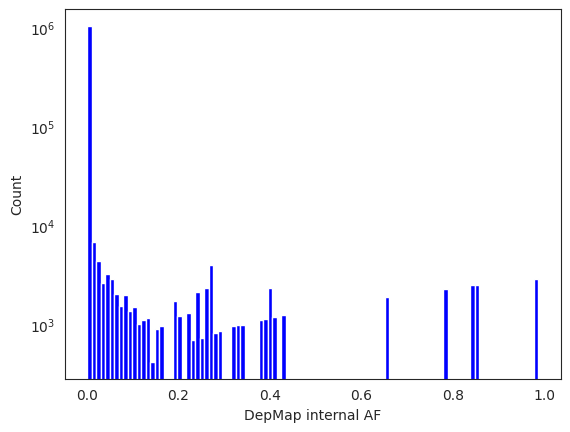

In [78]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
_ = ax.hist(maf_variants_23q4_clean["internal_afs_23q4"], color='blue', bins=100)
ax.set_yscale('log')
ax.set_xlabel("DepMap internal AF")
ax.set_ylabel("Count")

In [79]:
maf_variants_23q4_clean.to_csv("23Q4_somatic_mutations_profile_drafted.maf", index=False, sep='\t')
max_recurrence = 0.05 
maf_variants_23q4_clean.query("internal_afs_23q4 <= @max_recurrence").to_csv(f"23Q4_somatic_mutations_profile_drafted_internal_af{max_recurrence}.maf", index=False, sep='\t')

In [80]:
maf_variants_23q4_clean.query("internal_afs_23q4 <= @max_recurrence").shape

(1058927, 98)

In [82]:
# Upload to Taiga for data version control

update = True
if update:
    new_dataset_id = tc.update_dataset(
        "23q4-mutation-maf-clean-4161",
        changes_description="this is a clean and standarised draft for 23Q4 maf of mutation",
        upload_files=[
            {
                "path": f"23Q4_somatic_mutations_profile_drafted_internal_af{max_recurrence}.maf",
                "name": "MAF", # optional, will use file name if not provided
                "format": "Raw", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        add_all_existing_files=True,
    )
else:
    new_dataset_id = tc.create_dataset(
        "23Q4_mutation_maf_clean",
        dataset_description="this is a clean and standarised draft for 23Q4 maf of mutation",
        upload_files=[
            {
                "path": f"23Q4_somatic_mutations_profile_drafted_internal_af{max_recurrence}.maf",
                "name": "MAF", # optional, will use file name if not provided
                "format": "Raw", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
    )

# new_dataset_id

No dataset version provided. Using version 1.
Uploading MAF to S3
Finished uploading MAF to S3
Uploading MAF to Taiga
Finished uploading MAF to Taiga
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/0c79c8a4852a4de19002a60298bc0abc


In [83]:
maf_variants_23q4_clean.query("(internal_afs_23q4 <= @max_recurrence) & (rescue)").to_csv("23Q4_rescue_list.csv")

In [84]:
maf_variants_23q4_clean.query("(internal_afs_23q4 <= @max_recurrence) & (rescue)").shape, maf_variants_23q4_clean.query("(internal_afs_23q4 <= @max_recurrence) & (rescue)").shape[0] / 2937

((19238, 98), 6.550221314266258)

In [85]:
update = True
if update:
    new_dataset_id = tc.update_dataset(
        "23q4-mutation-rescuelist-6aa7",
        changes_description="this is a union set of the variants that are considered as whitelisting mutation", # optional (but recommended)
        upload_files=[
            {
                "path": "23Q4_rescue_list.csv",
                "name": "RescueList", # optional, will use file name if not provided
                "format": "TableCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        add_all_existing_files=True,
    )

No dataset version provided. Using version 4.
Uploading RescueList to S3
Finished uploading RescueList to S3
Uploading RescueList to Taiga
Finished uploading RescueList to Taiga
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/b3d3093e4ce7494ea05323a5ccf328cc


In [86]:
maf_variants_23q4_clean.query("Datatype=='wgs'").to_csv("23Q4_somatic_mutations_profile_drafted_wgs.maf", index=False, sep='\t')
max_recurrence = 0.05
maf_variants_23q4_clean.query("(internal_afs_23q4 <= @max_recurrence) & (Datatype=='wgs')").to_csv(f"23Q4_somatic_mutations_profile_drafted_internal_af{max_recurrence}_wgs.maf", index=False, sep='\t')

In [87]:
maf_variants_23q4_clean.sift.isnull().sum(), maf_variants_23q4_clean.shape

(245862, (1113655, 98))

In [88]:
(maf_variants_23q4_clean.Hugo_Symbol == 'MUC3A').sum(), maf_variants_23q4_clean.shape

(7986, (1113655, 98))

In [89]:
maf_variants_23q4_clean.loc[maf_variants_23q4_clean.Hugo_Symbol == 'TTN', :].value_counts("oncotree")[:20]

oncotree
COAD        599
MEL         507
SCLC        310
LUAD        267
UCEC        203
STAD        125
LUSC         97
GB           91
SKCM         89
PAAD         84
NSCLC        73
ESCC         71
OCSC         71
TLL          65
PRAD         58
BRCA         53
BLL          52
ESCA         51
UASC         43
DLBCLNOS     42
dtype: int64

In [90]:
# Too many oncotree information
maf_variants_23q4_clean.oncotree.unique().shape, maf_variants_23q4_clean.oncotree.unique()

((218,),
 array(['LUAD', 'MEL', 'BRCA', 'RCC', 'PAAD', 'ESCC', 'DLBCLNOS', 'BLL',
        'ESCA', 'COAD', 'IDC', 'STAD', 'OCSC', 'PRAD', 'AML', 'CCOV',
        'MBL', 'HGSOC', 'UCCA', 'LUSC', 'TLL', 'ES', 'CCRCC', 'BLCA',
        'ATRT', nan, 'UCEC', 'SKCM', 'HCC', 'CML', 'LCLC', 'EOV', 'ARMS',
        'SCLC', 'GB', 'MCC', 'BPLL', 'UASC', 'NBL', 'ATLL', 'STAS',
        'NSCLC', 'SOC', 'TSTAD', 'LUCA', 'FIBS', 'BL', 'COADREAD', 'LIPO',
        'AMOL', 'READ', 'MNG', 'ZIMMBL', 'EMBCA', 'ALCLALKN', 'CEAD', 'OS',
        'HNSC', 'HCL', 'ZHYPP', 'GCB', 'PLBMESO', 'ALCLALKP', 'BNNOS',
        'ASTR', 'PCM', 'ILC', 'PLEMESO', 'MFH', 'CMLBCRABL1', 'HL', 'MTNN',
        'DSTAD', 'NKCLL', 'ZMNOR', 'AM', 'LUAS', 'LXSC', 'ACRM', 'AMPCA',
        'CLLSLL', 'CEGCC', 'ZFIBSKI', 'PEL', 'HCCIHCH', 'TT', 'ASPS',
        'AASTR', 'UM', 'PMBL', 'MRT', 'PANET', 'MOV', 'HSTCL', 'VSC',
        'THAP', 'CSCC', 'PAASC', 'ECAD', 'ALAL', 'CESC', 'LMS', 'MBN',
        'MACR', 'LUMEC', 'BLSC', 'RMS', 'MYCF', 'IHCH

In [92]:
# Splitted mafs by the oncotree informations 

# for cancer_type in maf_variants_23q4_clean.oncotree.unique():
for cancer_type in ['READ', 'ESCA', 'AML', 'LUSC', 'SKCM', 'LUAD']:
    print(cancer_type)
    cancer_type_maf = maf_variants_23q4_clean.query("oncotree == @cancer_type")
    cancer_type_maf.to_csv(f"23Q4_somatic_mutations_profile_drafted_{cancer_type}.maf", index=False, sep='\t')

READ
ESCA
AML
LUSC
SKCM
LUAD


In [93]:
# Splitted mafs by the oncotree informations 

# for cancer_type in maf_variants_23q4_clean.oncotree.unique():
for cancer_type in ['READ', 'ESCA', 'AML', 'LUSC', 'LUAD', 'SKCM']:
    print(cancer_type)
    cancer_type_maf = maf_variants_23q4_clean.query("(oncotree == @cancer_type) & (internal_afs_23q4 < @max_recurrence)")
    cancer_type_maf.to_csv(f"23Q4_somatic_mutations_profile_drafted_{cancer_type}_internal_af{max_recurrence}.maf", index=False, sep='\t')

READ
ESCA
AML
LUSC
LUAD
SKCM


In [94]:
# Splitted mafs by the oncotree informations 

# for cancer_type in maf_variants_23q4_clean.oncotree.unique():
for cancer_type in ['READ', 'ESCA', 'AML', 'LUSC', 'LUAD', 'SKCM']:
    print(cancer_type)
    cancer_type_maf = maf_variants_23q4_clean.query("(oncotree == @cancer_type) & (internal_afs_23q4 < @max_recurrence) & (Datatype == 'wgs')")
    cancer_type_maf.to_csv(f"23Q4_somatic_mutations_profile_drafted_{cancer_type}_internal_af{max_recurrence}_wgs.maf", index=False, sep='\t')

READ
ESCA


AML
LUSC
LUAD
SKCM


In [95]:
# Merge all the subtypes of ovarian cancers
maf_variants_23q4_clean_ov_type = maf_variants_23q4_clean.loc[~maf_variants_23q4_clean.oncotree.isnull(), :]
maf_variants_23q4_clean_ov_type = maf_variants_23q4_clean_ov_type.loc[maf_variants_23q4_clean_ov_type.oncotree.str.contains('OV'), :]
maf_variants_23q4_clean_ov_type.to_csv(f"23Q4_somatic_mutations_profile_drafted_OV.maf", index=False, sep='\t')

In [96]:
maf_variants_23q4_clean_ov_type = maf_variants_23q4_clean.loc[~maf_variants_23q4_clean.oncotree.isnull(), :]
maf_variants_23q4_clean_ov_type = maf_variants_23q4_clean_ov_type.loc[(maf_variants_23q4_clean_ov_type.oncotree.str.contains('OV')) & (maf_variants_23q4_clean_ov_type.internal_afs_23q4 < max_recurrence), :]
maf_variants_23q4_clean_ov_type.to_csv(f"23Q4_somatic_mutations_profile_drafted_OV_internal_af{max_recurrence}.maf", index=False, sep='\t')

In [97]:
# Miss two only St Jude InDel now

## MONOMAC1	chr11.47355346.GC.	chr11.47355353.CGCC.CC	InDel	TP53	NA
## SKNAS	chr6.156778971..GCA	chr6.156778980.GG.GCAGG	InDel
## For St Jude results to be left-aligned as well
maf_variants_23q4_clean.query("internal_afs_23q4 <= @max_recurrence").loc[maf_variants_23q4_clean.query("internal_afs_23q4 <= @max_recurrence").pos.isin(np.array([105272634, 41224922, 124064038, 48791113, 23803335, 7675067, 47355346, 68293321, 156778971, 226064457, 49041176]) - 1), ].shape

(23, 98)

# Check sample specific question

## 1. The mutations of MTAP don't match with uniprot and ncbi

I found that many of the mutations of MTAP (Uniprot ID: Q13126) don’t match with any sequence from uniprot or ncbi. For example, HCT116 has a mutation p.V106A, but on uniprot, the 106 should be R. And there are many other mutations of MTAP have the same problem.

Answer: We actually do not have such a protein version in this drafted version, thus we checked the original output of maf from vcf_to_depmap, there is still no such a position

In [98]:
maf_variants_23q4_clean_internal_af_filter = maf_variants_23q4_clean.query("internal_afs_23q4 <= @max_recurrence")

In [99]:
maf_variants_23q4_clean_internal_af_filter.loc[(maf_variants_23q4_clean_internal_af_filter.Hugo_Symbol == 'MTAP'), ['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2', 'uniprot_id', 'Protein_Change']]

,Chromosome,Start_Position,Reference_Allele,Tumor_Seq_Allele2,uniprot_id,Protein_Change
154606,chr9,21815485,G,T,Q13126-1,ENSP00000494373.1:p.Arg29Ile
517994,chr9,21816739,A,C,Q13126-1,ENSP00000494373.1:p.Lys49Thr
996343,chr9,21816749,T,G,Q13126-1,ENSP00000494373.1:p.Asn52Lys
139386,chr9,21816774,T,C,Q13126-1,NaN
517995,chr9,21816774,T,C,Q13126-1,NaN
881589,chr9,21816774,T,C,Q13126-1,NaN
129344,chr9,21818039,G,T,Q13126-1,ENSP00000494373.1:p.Gly62Ter
68949,chr9,21818040,G,A,Q13126-1,ENSP00000494373.1:p.Gly62Glu
287043,chr9,21818121,T,C,Q13126-1,ENSP00000494373.1:p.Val89Ala
885431,chr9,21818121,T,C,Q13126-1,ENSP00000494373.1:p.Val89Ala


In [100]:
release_maf_23q2.loc[release_maf_23q2.loc[:, 'HugoSymbol'] == 'MTAP', ['Chrom', 'Pos', 'Ref', 'Alt', 'HugoSymbol', 'UniprotID', 'ProteinChange', 'DNAChange']].head(8)

,Chrom,Pos,Ref,Alt,HugoSymbol,UniprotID,ProteinChange,DNAChange
38983,chr9,21818202,G,T,MTAP,Q13126,p.R133M,c.398G>T
44775,chr9,21818170,C,T,MTAP,Q13126,p.G122G,c.366C>T
102146,chr9,21816774,T,C,MTAP,Q13126,None,c.e3+2T>C
102147,chr9,21818047,G,A,MTAP,Q13126,p.Q81Q,c.243G>A
108288,chr9,21818121,T,C,MTAP,Q13126,p.V106A,c.317T>C
373342,chr9,21861985,C,T,MTAP,Q13126,p.Q292*,c.874C>T
386378,chr9,21854714,C,T,MTAP,Q13126,p.S195S,c.585C>T
534264,chr9,21931194,A,G,MTAP,Q13126,p.S334G,c.1000A>G


## KRAS G12D mutation

The PANC1005 line is well characterized as having a KRAS G12D mutation, but this is missing from the latest release of DepMap data while present in the older releases. Is this is indeed the case or have I made a mistake in querying the data?

Answer: we actually found the G12D mutation (Gly12Asp). We double checked 23Q2, it is not there.

In [101]:
maf_variants_23q4_clean.loc[(maf_variants_23q4_clean.celltype == 'PANC1005') & (maf_variants_23q4_clean.Hugo_Symbol == 'KRAS'), ['uniprot_id', 'Protein_Change']]

,uniprot_id,Protein_Change
45392,P01116-2,ENSP00000308495.3:p.Gly12Asp
1063512,P01116-2,ENSP00000308495.3:p.Gly12Asp


In [102]:
max_recurrence

0.05

In [103]:
maf_variants_23q4_clean_internal_af_filter = maf_variants_23q4_clean.query("internal_afs_23q4 <= @max_recurrence")

maf_variants_23q4_clean_internal_af_filter.loc[(maf_variants_23q4_clean_internal_af_filter.celltype == 'PANC1005') & (maf_variants_23q4_clean_internal_af_filter.Hugo_Symbol == 'KRAS'), ['uniprot_id', 'Protein_Change']]

,uniprot_id,Protein_Change
45392,P01116-2,ENSP00000308495.3:p.Gly12Asp
1063512,P01116-2,ENSP00000308495.3:p.Gly12Asp


In [104]:
ids_23q2_g12d = release_maf_23q2.loc[release_maf_23q2.loc[:, 'ProteinChange'] == 'p.G12D', ['ModelID', 'Ref', 'Alt', 'HugoSymbol', 'UniprotID', 'ProteinChange', 'DNAChange']]

In [105]:
oncotree_meta_profile.ModelID

0       ACH-000486
1       ACH-000627
2       ACH-001131
3       ACH-000042
4       ACH-000957
           ...    
8705    ACH-000710
8706    ACH-000245
8707    ACH-003308
8708    ACH-000650
8709    ACH-000171
Name: ModelID, Length: 8710, dtype: object

In [106]:
oncotree_meta_profile.loc[oncotree_meta_profile.ModelID.isin(ids_23q2_g12d.ModelID), 'StrippedCellLineName'].isin(['PANC1005']).sum()

0

## Mutation and protein change

“I have spent a bit of time trying to align the residue numbering on
targets/mutations in DepMap to other public databases.  For some reason the
sequence variants DepMap uses for assigning residue numbers are different
than those used for all other datasources I use.  For example on EGFR, the
common mutations L858R and T790M are listed as “L813R” and “T745M”.  Other
databases like COSMIC, TCGA/cBioPortal, and our own internal database do
not have this issue – the residue numbering on 99%+ of proteins is
identical between the other databases, but then DepMap numbering is
different.

Answer: L858R and T790M now can be found in the 23Q4 version. 

In [107]:
# L858R
maf_variants_23q4_clean.query("internal_afs_23q4 <= @max_recurrence").query("Hugo_Symbol == 'EGFR' & Protein_Change.str.contains('Leu')")['Protein_Change']

683459                   ENSP00000275493.2:p.Phe48Leu
671443                   ENSP00000275493.2:p.Leu62Arg
1063253                  ENSP00000275493.2:p.Gln71Leu
623088                   ENSP00000275493.2:p.Leu76Pro
669250                  ENSP00000275493.2:p.Val292Leu
665425                  ENSP00000275493.2:p.Ser306Leu
316046           ENSP00000275493.2:p.Leu747_Glu749del
535312           ENSP00000275493.2:p.Leu747_Glu749del
541517           ENSP00000275493.2:p.Leu747PhefsTer14
669405     ENSP00000275493.2:p.Leu747_Pro753delinsSer
485254                  ENSP00000275493.2:p.Leu858Arg
643298                  ENSP00000275493.2:p.Leu858Arg
957147                  ENSP00000275493.2:p.Leu858Arg
1098765                 ENSP00000275493.2:p.Leu858Arg
51407                   ENSP00000275493.2:p.Leu861Gln
109229                  ENSP00000275493.2:p.Leu883Phe
201553                  ENSP00000275493.2:p.Leu883Phe
386012                  ENSP00000275493.2:p.Phe961Leu
Name: Protein_Change, dtype:

In [108]:
# Thr790Met -> T790M
maf_variants_23q4_clean.query("internal_afs_23q4 <= @max_recurrence").query("Hugo_Symbol == 'EGFR' & Protein_Change.str.contains('Thr')")['Protein_Change']

1084322     ENSP00000275493.2:p.Ala289Thr
866408      ENSP00000275493.2:p.Ser366Thr
148684      ENSP00000275493.2:p.Thr751Ile
844772      ENSP00000275493.2:p.Thr751Ile
485253      ENSP00000275493.2:p.Thr790Met
1098764     ENSP00000275493.2:p.Thr790Met
876804      ENSP00000275493.2:p.Thr903Ile
17533       ENSP00000275493.2:p.Thr940Ala
855329      ENSP00000275493.2:p.Thr940Ala
732439     ENSP00000275493.2:p.Ser1025Thr
103985     ENSP00000275493.2:p.Ala1076Thr
754298     ENSP00000275493.2:p.Ala1076Thr
126327     ENSP00000275493.2:p.Thr1085Asn
599306     ENSP00000275493.2:p.Ala1132Thr
Name: Protein_Change, dtype: object

## Incorrect germline mutation
I had a question that I didn’t want to post to the forum but ask rather privately:
In the gene RBM10:

  *   ACH-000875 has a variant c.e20+1G>T marked as deleterious in 22q2 but not deleterious in 23q2
  *   ACH-000414 (NCIH1944) has a frameshift p.P617fs in 22q2 but SNP p.V616F in 23q2
Could you please clarify the first point as to changes in variant classification and for the second point what changed in the variant caller to call a frameshift a SNP instead? According to CBIOportal CCLE data on NCIH1944 it should also have a frameshift A540Rfs*10 but I don’t think this is in the mutation calls. Would be great to understand the underlying reason.


Answer: 
1. ACH-00875 will have this high impact mutation in 23Q4 as deleterious 
2. We will have both frameshift ENSP00000366829.3:p.Ala618ArgfsTer10 and SNP p.Val616Phe for 23Q4.

In [109]:
maf_variants_23q4_clean.query("internal_afs_23q4 <= @max_recurrence").query("ModelID == 'ACH-000875' & Hugo_Symbol == 'RBM10'")[['vep_impact', 'dna_change', 'Protein_Change']]

,vep_impact,dna_change,Protein_Change
166988,HIGH,ENST00000377604.8:c.2355+1G>T,NaN


In [110]:
maf_variants_23q4_clean.query("internal_afs_23q4 <= @max_recurrence").query("ModelID == 'ACH-000414' & Hugo_Symbol == 'RBM10'")[['vep_impact', 'variant_info', 'dna_change', 'Protein_Change']]

,vep_impact,variant_info,dna_change,Protein_Change
359207,MODERATE,missense_variant,ENST00000377604.8:c.1846G>T,ENSP00000366829.3:p.Val616Phe
425920,MODERATE,missense_variant,ENST00000377604.8:c.1846G>T,ENSP00000366829.3:p.Val616Phe
359208,HIGH,frameshift_variant,ENST00000377604.8:c.1851dup,ENSP00000366829.3:p.Ala618ArgfsTer10
425921,HIGH,frameshift_variant,ENST00000377604.8:c.1851dup,ENSP00000366829.3:p.Ala618ArgfsTer10


## L858R hotspot

L858R hotspot is being annotated as L813R and exon 19 deletions should be between 729-761 and most common in-frame del in our data is annotated at 701. Wanted to flag this for you and something to check with our new annotations.

Answer: this has been annotated as ENSP00000275233.7:p.Leu858ArgfsTer47 by VEP now. We also have a few missense mutations

In [111]:
maf_variants_23q4_clean_l585r = maf_variants_23q4_clean.query("internal_afs_23q4 <= @max_recurrence").loc[~maf_variants_23q4_clean.query("internal_afs_23q4 <= @max_recurrence").Protein_Change.isnull(), :]
maf_variants_23q4_clean_l585r.loc[maf_variants_23q4_clean_l585r.Protein_Change.str.contains('Leu858Arg'), ['Protein_Change', 'vep_impact', 'variant_info']]

,Protein_Change,vep_impact,variant_info
853764,ENSP00000473211.1:p.Leu858Arg,MODERATE,missense_variant
326455,ENSP00000275233.7:p.Leu858ArgfsTer47,HIGH,frameshift_variant
485254,ENSP00000275493.2:p.Leu858Arg,MODERATE,missense_variant
643298,ENSP00000275493.2:p.Leu858Arg,MODERATE,missense_variant
957147,ENSP00000275493.2:p.Leu858Arg,MODERATE,missense_variant
1098765,ENSP00000275493.2:p.Leu858Arg,MODERATE,missense_variant


## Start codon change classification


- The OmicsSomaticMutationsMAFProfile.maf file registers missense mutants in the start codon as “silent” when in fact the mutation will most likely lead to a loss of function. I’ve noticed this in one specific gene of interest, but there could be more.
Interestingly, the OmicsSomaticMutations.csv file recognizes it as a START_CODON_SNP and marks the mutant as gene_function_loss .
The contents of OmicsSomaticMutationsMAFProfile.maf
GNA11 GRCh38 19 3094654 3094655 SNP G G A PR-Ds9QdK Silent p.M1I
GNA11 GRCh38 19 3094654 3094655 SNP G G A PR-Yz6AIC Silent p.M1I

- The contents of OmicsSomaticMutations.csv
chr19,3094654,G,A,0.286,9,3,0/1,,SNP,START_CODON_SNP,c.3G>A,p.M1I,GNA11,G protein subunit alpha 11,"G protein subunits alpha, group q",ENST00000078429.9,1.0,+,P29992,False,,,,0.8029925187032418,E,Dom,False,,False,,gene_function_loss;,False,False,False,,,,,7.3,False,True,False,,0.921563,0.9822536945303076,0.596,4.0,,,,,,,ACH-000995,2767.0


In [112]:
maf_variants_23q4_clean_internal_af_filter.query("Start_Position == 3094654")[['Chromosome', 'Start_Position', 'Variant_Classification', 'vep_impact']]

,Chromosome,Start_Position,Variant_Classification,vep_impact
175995,chr19,3094654,Translation_Start_Site,HIGH
430785,chr19,3094654,Translation_Start_Site,HIGH


# Statistics Compared to Past release

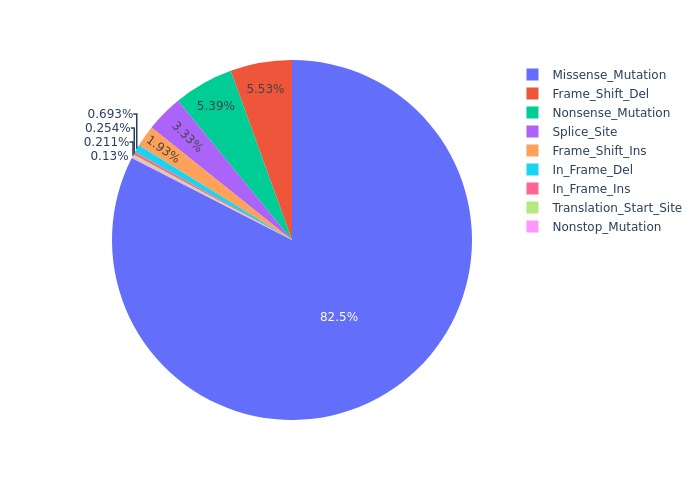

In [113]:
import plotly.express as px
fig = px.pie(maf_variants_23q4_clean_internal_af_filter['Variant_Classification'].value_counts().reset_index(), names="index", values="Variant_Classification")
fig.show()

In [114]:
release_maf_23q2_stat = release_standard_maf_23q2.value_counts('Variant_Classification').reset_index().rename({0: 'counts'}, axis=1)

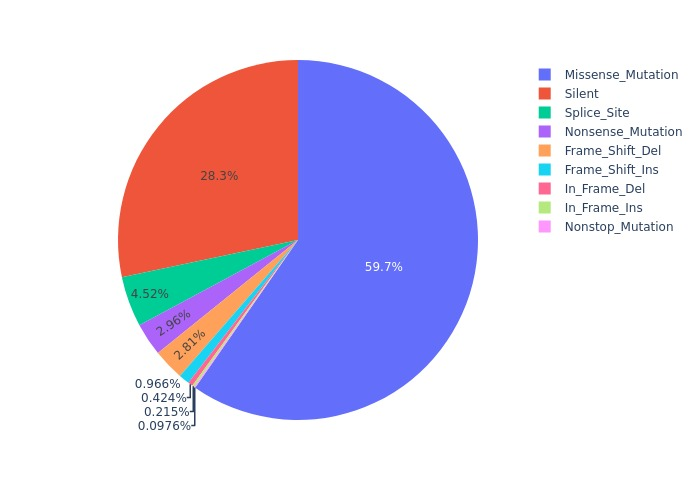

In [115]:
import plotly.express as px
fig = px.pie(release_maf_23q2_stat, names="Variant_Classification", values="counts")
fig.show()